# Script to add load, generators, missing lines and transformers to SciGRID


# WARNING: This script is no longer supported, since the libraries and data no longer exist in their former versions

# It is kept here for interest's sake

# See https://github.com/PyPSA/pypsa-eur for a newer model that covers all of Europe


This Jupyter Notebook is also available to download at: <http://www.pypsa.org/examples/add_load_gen_trafos_to_scigrid.ipynb>  and can be viewed as an HTML page at: http://pypsa.org/examples/add_load_gen_trafos_to_scigrid.html.

This script does some post-processing on the original SciGRID dataset version 0.2 and then adds load, generation, transformers and missing lines to the SciGRID dataset.

The intention is to create a model of the German electricity system that is transparent in the sense that all steps from openly-available raw data to the final model can be followed. The model is NOT validated and may contain errors.

Some of the libraries used for attaching the load and generation are not on github, but can be downloaded at

http://fias.uni-frankfurt.de/~hoersch/

The intention is to release these as free software soon. We cannot guarantee to support you when using these libraries.



## Data sources

Grid: based on [SciGRID](http://scigrid.de/) Version 0.2 which is based on [OpenStreetMap](http://www.openstreetmap.org/).

Load size and location: based on Landkreise (NUTS 3) GDP and population.

Load time series: from ENTSO-E hourly data, scaled up uniformly by factor 1.12 (a simplification of the methodology in Schumacher, Hirth (2015)).

Conventional power plant capacities and locations: BNetzA list.

Wind and solar capacities and locations: EEG Stammdaten, based on  http://www.energymap.info/download.html, which represents capacities at the end of 2014. Units without PLZ are removed.

Wind and solar time series: REatlas, Andresen et al, "Validation of Danish wind time series from a new global renewable energy atlas for energy system analysis," Energy 93 (2015) 1074 - 1088.

NB:

All times in the dataset are UTC.

Where SciGRID nodes have been split into 220kV and 380kV substations, all load and generation is attached to the 220kV substation.

## Warning

This dataset is ONLY intended to demonstrate the capabilities of PyPSA and is NOT (yet) accurate enough to be used for research purposes.

Known problems include:

i) Rough approximations have been made for missing grid data, e.g. 220kV-380kV transformers and connections between close sub-stations missing from OSM.

ii) There appears to be some unexpected congestion in parts of the network, which may mean for example that the load attachment method (by Voronoi cell overlap with Landkreise) isn't working, particularly in regions with a high density of substations.

iii) Attaching power plants to the nearest high voltage substation may not reflect reality.

iv) There is no proper n-1 security in the calculations - this can either be simulated with a blanket e.g. 70% reduction in thermal limits (as done here) or a proper security constrained OPF (see e.g.  <http://www.pypsa.org/examples/scigrid-sclopf.ipynb>).

v) The borders and neighbouring countries are not represented.

vi) Hydroelectric power stations are not modelled accurately.

viii) The marginal costs are illustrative, not accurate.

ix) Only the first day of 2011 is in the github dataset, which is not representative. The full year of 2011 can be downloaded at <http://www.pypsa.org/examples/scigrid-with-load-gen-trafos-2011.zip>.

x) The ENTSO-E total load for Germany may not be scaled correctly; it is scaled up uniformly by factor 1.12 (a simplification of the methodology in Schumacher, Hirth (2015), which suggests monthly factors).

xi) Biomass from the EEG Stammdaten are not read in at the moment.

xii) Power plant start up costs, ramping limits/costs, minimum loading rates are not considered.


In [44]:
# make the code as Python 3 compatible as possible
from __future__ import print_function, division,absolute_import

import pypsa

import pandas as pd

import numpy as np

from six import iteritems
from six.moves import range

import os

import matplotlib.pyplot as plt

%matplotlib inline

## Read in the raw SciGRID data

In [45]:
#You may have to adjust this path to where 
#you downloaded the github repository
#https://github.com/PyPSA/PyPSA

folder_prefix =  "scigrid-de/"

In [46]:
#note that some columns have 'quotes because of fields containing commas'
vertices = pd.read_csv(folder_prefix+"scigrid-151109/vertices_de_power_151109.csvdata",sep=",",quotechar="'",index_col=0)

vertices.rename(columns={"lon":"x","lat":"y","name":"osm_name"},inplace=True)

In [47]:
print(vertices["voltage"].value_counts(dropna=False))

220000;110000                 129
380000;110000                 101
380000;220000;110000           64
220000                         62
380000                         58
NaN                            34
380000;220000                  24
220000;65000                    3
110000                          3
400000                          2
150000                          2
400000;220000                   2
400000;220000;110000            2
400000;220000;150000            1
220000;155000                   1
380000;150000;110000            1
380000;220000;110000;20000      1
380000;110000;20000             1
400000;130000                   1
400000;225000                   1
220000;150000;60000             1
400000;225000;90000             1
Name: voltage, dtype: int64


In [48]:
links = pd.read_csv(folder_prefix+"scigrid-151109/links_de_power_151109.csvdata",sep=",",quotechar="'",index_col=0)
links.rename(columns={"v_id_1":"bus0","v_id_2":"bus1","name":"osm_name"},inplace=True)

links["cables"].fillna(3,inplace=True)
links["wires"].fillna(2,inplace=True)

links["length"] = links["length_m"]/1000.

In [49]:
print(links["voltage"].value_counts(dropna=False))

380000    422
220000    399
300000      2
400000      1
450000      1
Name: voltage, dtype: int64


In [50]:
## Drop the DC lines

for voltage in [300000,400000,450000]:
    links.drop(links[links.voltage == voltage].index,inplace=True)

In [51]:
## Build the network

network = pypsa.Network()

pypsa.io.import_components_from_dataframe(network,vertices,"Bus")

pypsa.io.import_components_from_dataframe(network,links,"Line")

## Add specific missing AC lines

In [52]:
# Add AC lines known to be missing in SciGRID                                                                                                             
# E.g. lines missing because of OSM mapping errors.                                                                                                       
# This is no systematic list, just what we noticed;                                                                                                       
# please tell SciGRID and/or Tom Brown (brown@fias.uni-frankfurt.de)                                                                                      
# if you know of more examples                                                                                                                            

columns = ["bus0","bus1","wires","cables","voltage"]

data = [["100","255",2,6,220000], # Niederstedem to Wengerohr                                                                                             
        ["384","351",4,6,380000], # Raitersaich to Ingolstadt                                                                                             
        ["351","353",4,6,380000], # Ingolstadt to Irsching                                                                                                
        ]

last_scigrid_line = int(network.lines.index[-1])

index = [str(i) for i in range(last_scigrid_line+1,last_scigrid_line+1 + len(data))]

missing_lines = pd.DataFrame(data,index,columns)

#On average, SciGRID lines are 25% longer than the direct distance
length_factor = 1.25

missing_lines["length"] = [length_factor*pypsa.geo.haversine(network.buses.loc[r.bus0,["x","y"]],network.buses.loc[r.bus1,["x","y"]])[0,0] for i,r in missing_lines.iterrows()]


In [53]:
pypsa.io.import_components_from_dataframe(network,missing_lines,"Line")

In [54]:
network.lines.tail()

,bus0,bus1,voltage,cables,wires,frequency,osm_name,operator,ref,length_m,...,v_ang_min,v_ang_max,sub_network,x_pu,r_pu,g_pu,b_pu,x_pu_eff,r_pu_eff,s_nom_opt
824,333,495,380000,6.0,2.0,50.0,Audorf - Jardelund,TenneT TSO GmbH,NaN,17345.0,...,-inf,inf,,0.0,0.0,0.0,0.0,0.0,0.0,0.0
825,398,495,380000,6.0,2.0,50.0,Audorf - Jardelund,TenneT TSO GmbH,NaN,64968.0,...,-inf,inf,,0.0,0.0,0.0,0.0,0.0,0.0,0.0
826,100,255,220000,6.0,2.0,NaN,NaN,NaN,NaN,NaN,...,-inf,inf,,0.0,0.0,0.0,0.0,0.0,0.0,0.0
827,384,351,380000,6.0,4.0,NaN,NaN,NaN,NaN,NaN,...,-inf,inf,,0.0,0.0,0.0,0.0,0.0,0.0,0.0
828,351,353,380000,6.0,4.0,NaN,NaN,NaN,NaN,NaN,...,-inf,inf,,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Determine the voltage of the buses by the lines which end there


In [55]:
network.lines.voltage.value_counts()

380000    424
220000    400
Name: voltage, dtype: int64

In [56]:

buses_by_voltage = {}

for voltage in network.lines.voltage.value_counts().index:
    buses_by_voltage[voltage] = set(network.lines[network.lines.voltage == voltage].bus0)\
                                | set(network.lines[network.lines.voltage == voltage].bus1)

In [57]:
# give priority to 380 kV
network.buses["v_nom"] = 380
network.buses.loc[buses_by_voltage[220000],"v_nom"] = 220
network.buses.loc[buses_by_voltage[380000],"v_nom"] = 380

In [58]:
network.buses.v_nom.value_counts(dropna=False)

380    277
220    218
Name: v_nom, dtype: int64

## Connect buses which are < 850m apart

There are pairs of buses less than 850m apart which are not connected in SciGRID, but clearly connected in OpenStreetMap (OSM).

The reason is that the relations for connections between close substations do not appear in OSM.

Here they are connected with 2 circuits of the appropriate voltage level (an asumption).

850m is chosen as a limit based on manually looking through the examples.

The example 46-48 (Marzahn) at 892 m apart is the first example of close substations which are not connected in reality.

In [59]:
# Compute the distances for unique pairs

pairs = pd.Series()

for i,u in enumerate(network.buses.index):
    vs = network.buses[["x","y"]].iloc[i+1:]
    distance_km = pypsa.geo.haversine(vs,network.buses.loc[u,["x","y"]])

    to_add = pd.Series(data=distance_km[:,0],index=[(u,v) for v in vs.index])
    
    pairs = pd.concat((pairs,to_add))

In [60]:
pairs.sort_values().head()

(443, 444)    0.024582
(465, 471)    0.038207
(483, 484)    0.075587
(250, 251)    0.089066
(419, 420)    0.100549
dtype: float64

In [61]:
# determine topology so we can look what's actually connected
network.determine_network_topology()

In [62]:
# Example all substations which are close to                                                                                                              
# each other geographically by not connected in network.adj                                                                                               

start = 0  #km                                                                                                                                            
stop = 1 #km                                                                                                                                              

for (u,v),dist in pairs.sort_values().iteritems():

    if dist < start:
        continue

    #only go up to pairs stop km apart                                                                                                                    
    if dist > stop:
        break

    #ignore if they're already connected                                                                                                                  
    if u in network.graph().adj[v]:
        continue


    print(u,v,dist)

    u_x = network.buses.at[u,"x"]
    u_y = network.buses.at[u,"y"]
    v_x = network.buses.at[v,"x"]
    v_y = network.buses.at[v,"y"]

    #have a look what's going on in OSM                                                                                                                   
    print("https://www.openstreetmap.org/#map=18/{}/{}".format(u_y,u_x))
    print("https://www.openstreetmap.org/#map=18/{}/{}".format(v_y,v_x))


465 471 0.03820668871585058
https://www.openstreetmap.org/#map=18/50.844152972213294/6.9290926908067405
https://www.openstreetmap.org/#map=18/50.84381694694/6.9289790539233
250 251 0.08906646694555641
https://www.openstreetmap.org/#map=18/51.6736430744508/7.7155434194964805
https://www.openstreetmap.org/#map=18/51.6730996381138/7.71459453349968
419 420 0.10054938224196001
https://www.openstreetmap.org/#map=18/54.3540286881643/6.02502872785802
https://www.openstreetmap.org/#map=18/54.3549329471359/6.0250329499398605
251 252 0.13928662532818753
https://www.openstreetmap.org/#map=18/51.6730996381138/7.71459453349968
https://www.openstreetmap.org/#map=18/51.672663662233/7.712700934310269
194 195 0.16228871174481868
https://www.openstreetmap.org/#map=18/51.577104777735/6.68306568260248
https://www.openstreetmap.org/#map=18/51.5756455059265/6.683106976638711
249 250 0.20105298512767003
https://www.openstreetmap.org/#map=18/51.6743422007117/7.7182323196274805
https://www.openstreetmap.org/#ma

In [63]:
# From examining the map, it seems that all cases where substations                                                                                       
# are less than 850m apart are connected in reality                                                                                                       
# The first one to fail is 46-48 (Marzahn) at 892 m                                                                                                       

# Connect these substations                                                                                                                               

limit = 0.85

for (u,v),dist in pairs.sort_values().iteritems():

    #only go up to pairs stop km apart                                                                                                                    
    if dist > limit:
        break

    #ignore if they're already connected                                                                                                                  
    if u in network.graph().adj[v]:
        continue


    kv_u = network.buses.at[u,"v_nom"]
    kv_v = network.buses.at[v,"v_nom"]

    print(u,v,dist,kv_u,kv_v)
    
    last_scigrid_line = int(network.lines.index[-1])
    
    voltage = max(kv_u,kv_v)*1000
    
    wires = {220000 : 2, 380000 : 4}[voltage]
    
    cables = 6
    
    df = pd.DataFrame([[u,v,length_factor*dist,wires,cables,voltage]],columns=["bus0","bus1","length","wires","cables","voltage"],index=[str(last_scigrid_line+1)])

    pypsa.io.import_components_from_dataframe(network,df,"Line")

465 471 0.03820668871585058 220 220
250 251 0.08906646694555641 220 220
419 420 0.10054938224196001 380 380
251 252 0.13928662532818753 220 220
194 195 0.16228871174481868 380 220
249 250 0.20105298512767003 380 220
2 296 0.21746771839311102 380 380
250 252 0.22423259083023564 220 220
54 367 0.23779054419895984 380 380
131 267 0.2552196209644153 380 220
91 92 0.26750391755327424 380 380
249 251 0.28638240410902943 380 220
186 191 0.29195750188668756 380 220
129 173 0.29597806877983884 220 380
96 202 0.3324318842950836 220 380
53 322 0.34972151265103335 380 220
24 398 0.3830410868781416 220 380
133 156 0.4095650297905685 380 220
448 458 0.41435380755268936 380 220
451 458 0.4150174566374426 380 220
249 252 0.42464327360333765 380 220
187 195 0.43950835093070706 380 220
216 236 0.4651787780538347 380 220
246 391 0.47717442560314915 380 220
396 410 0.5207310659013165 380 380
448 451 0.5903599370343385 380 380
448 450 0.6085019107703462 380 380
198 478 0.7740340991737793 380 380
470 473 0.

## Split buses with more than one voltage; add trafos between

This code splits the buses where you have 220 and 380 kV lines landing.

In [64]:
network.lines.voltage.value_counts()

380000    451
220000    404
Name: voltage, dtype: int64

In [65]:

buses_by_voltage = {}

for voltage in network.lines.voltage.value_counts().index:
    buses_by_voltage[voltage] = set(network.lines[network.lines.voltage == voltage].bus0)\
                                | set(network.lines[network.lines.voltage == voltage].bus1)

In [66]:
network.buses.v_nom=380
network.buses.loc[buses_by_voltage[220000],"v_nom"] = 220
network.buses.loc[buses_by_voltage[380000],"v_nom"] = 380

In [67]:
overlap = buses_by_voltage[220000] & buses_by_voltage[380000]
len(overlap)

96

In [68]:
## build up new buses and transformers to import


buses_to_split = [str(i) for i in sorted([int(item) for item in overlap])]
buses_to_split_df = network.buses.loc[buses_to_split]

buses_to_split_df.v_nom = 220

buses_to_split_220kV = [name + "_220kV" for name in buses_to_split_df.index]

buses_to_split_df.index = buses_to_split_220kV

trafos_df = pd.DataFrame(index=buses_to_split)
trafos_df["bus0"] = buses_to_split
trafos_df["bus1"] = buses_to_split_220kV
trafos_df["x"] = 0.1
#This high a nominal power is required for feasibility in LOPF
trafos_df["s_nom"] = 2000

In [69]:
pypsa.io.import_components_from_dataframe(network,buses_to_split_df,"Bus")
pypsa.io.import_components_from_dataframe(network,trafos_df,"Transformer")

In [70]:
##reconnect lines to the correct voltage bus

for line in network.lines.index:
    bus0 = network.lines.at[line,"bus0"]
    bus1 = network.lines.at[line,"bus1"]
    v0 = network.buses.at[bus0,"v_nom"]
    v1 = network.buses.at[bus1,"v_nom"]
    v = network.lines.at[line,"voltage"]
    if v0 != v/1000.:
        print(line,v0,v)
        network.lines.at[line,"bus0"] = bus0+"_220kV"
    if v1 != v/1000.:
        network.lines.at[line,"bus1"] = bus1+"_220kV"

3 380.0 220000
6 380.0 220000
8 380.0 220000
9 380.0 220000
16 380.0 220000
19 380.0 220000
32 380.0 220000
40 380.0 220000
41 380.0 220000
52 380.0 220000
53 380.0 220000
58 380.0 220000
78 380.0 220000
99 380.0 220000
127 380.0 220000
133 380.0 220000
140 380.0 220000
143 380.0 220000
145 380.0 220000
156 380.0 220000
157 380.0 220000
160 380.0 220000
161 380.0 220000
165 380.0 220000
166 380.0 220000
167 380.0 220000
170 380.0 220000
171 380.0 220000
172 380.0 220000
173 380.0 220000
176 380.0 220000
180 380.0 220000
193 380.0 220000
195 380.0 220000
196 380.0 220000
198 380.0 220000
199 380.0 220000
203 380.0 220000
206 380.0 220000
208 380.0 220000
209 380.0 220000
223 380.0 220000
224 380.0 220000
228 380.0 220000
229 380.0 220000
234 380.0 220000
235 380.0 220000
236 380.0 220000
237 380.0 220000
240 380.0 220000
243 380.0 220000
244 380.0 220000
262 380.0 220000
275 380.0 220000
278 380.0 220000
283 380.0 220000
306 380.0 220000
308 380.0 220000
314 380.0 220000
322 380.0 22000

In [71]:
#determine the connected components

network.determine_network_topology()


#remove small isolated networks
for sn in network.sub_networks.obj:
    buses = sn.buses().index
    branches = sn.branches().index
    
    if len(buses) < 5:
        print("Dropping Sub-Network {} because it only has {} buses".format(sn,len(buses)))
        #print(buses.index)
        #print(len(branches),branches.index)
        for bus in buses:
            network.remove("Bus",bus)
        for branch in branches:
            network.remove("Line",branch[1])
    else:
        print("Keeping Sub-Network {} because it has {} buses".format(sn,len(buses)))

#rebuild topology

network.determine_network_topology()

Keeping Sub-Network SubNetwork 0 because it has 585 buses
Dropping Sub-Network SubNetwork 1 because it only has 2 buses
Dropping Sub-Network SubNetwork 2 because it only has 1 buses
Dropping Sub-Network SubNetwork 3 because it only has 1 buses
Dropping Sub-Network SubNetwork 4 because it only has 2 buses


(<matplotlib.collections.PathCollection at 0x7f65bc6ffdd8>,
 <matplotlib.collections.LineCollection at 0x7f65bc709320>)

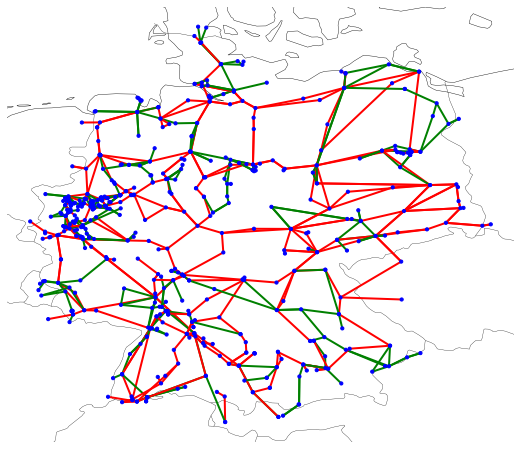

In [79]:
plt.figure(figsize=(10,8))
colors = network.lines.voltage.map(lambda v: "g" if v == 220000 else "r" if v == 380000 else "c")
network.plot(line_colors=colors)

## Recalculate all electrical properties

In [35]:
network.lines["type"] = network.lines.voltage.map({220000 : "Al/St 240/40 2-bundle 220.0",
                                                   380000 : "Al/St 240/40 4-bundle 380.0"})

network.lines["num_parallel"] = network.lines.cables/3.*network.lines.wires/network.lines.voltage.map({220000 : 2., 380000 : 4.})

network.lines["s_nom"] = 3.**0.5*network.lines.voltage/1000.*network.lines.num_parallel*network.lines.voltage.map({220000 : 2., 380000 : 4.})*0.65

# Attach the load

In [36]:
#import FIAS libraries for attaching data

#this script uses old versions of the FIAS libraries and 
#has not yet been updated to the new versions

#the latest versions are available at
#https://github.com/FRESNA/vresutils

#if you get it working with the new versions, please
#tell us! It shouldn't be too hard...

try:
    import vresutils, load
except:
    print("Oh dear! You don't have FIAS libraries, so you cannot add load :-(")

Oh dear! You don't have FIAS libraries, so you cannot add load :-(


In [37]:
import load

ModuleNotFoundError: No module named 'load'

In [38]:
from vresutils import graph as vgraph
from vresutils import shapes as vshapes
from vresutils import grid as vgrid
from vresutils import dispatch as vdispatch
from shapely.geometry import Polygon
from load import germany as DEload
import networkx as nx

ModuleNotFoundError: No module named 'vresutils'

In [34]:

#bounding poly for Germany for the Voronoi - necessary
#because some SciGRID points lie outside border vshapes.germany()
poly = Polygon([[5.8,47.],[5.8,55.5],[15.2,55.5],[15.2,47.]])

In [35]:
def generate_dummy_graph(network):
    """Generate a dummy graph to feed to the FIAS libraries.
    It adds the "pos" attribute and removes the 380 kV duplicate
    buses when the buses have been split, so that all load and generation
    is attached to the 220kV bus."""
    
    graph = pypsa.descriptors.OrderedGraph()
    
    graph.add_nodes_from([bus for bus in network.buses.index if bus not in buses_to_split])
    
    #add positions to graph for voronoi cell computation
    for node in graph.nodes():
        graph.node[node]["pos"] = np.array(network.buses.loc[node,["x","y"]],dtype=float)
    
    return graph

In [36]:
graph = generate_dummy_graph(network)

In [37]:
graph.name = "scigrid_v2"

In [38]:
def voronoi_partition(G, outline):
    """                                                                                                                                                   
    For 2D-embedded graph `G`, within the boundary given by the shapely polygon                                                                           
    `outline`, returns `G` with the Voronoi cell region as an additional node                                                                             
    attribute.                                                                                                                                            
    """
    #following line from vresutils.graph caused a bug
    #G = polygon_subgraph(G, outline, copy=False)
    points = list(vresutils.graph.get_node_attributes(G, 'pos').values())
    regions = vresutils.graph.voronoi_partition_pts(points, outline, no_multipolygons=True)
    nx.set_node_attributes(G, 'region', dict(zip(G.nodes(), regions)))

    return G


In [39]:
voronoi_partition(graph, poly)

In [40]:
#NB: starts at midnight CET, 23:00 UTC
load = DEload.timeseries(graph, years=[2011, 2012, 2013, 2014])

Serving call to read_entsoe_consumption from file load.europe.read_entsoe_consumption_2011_2012_2013_2014_countries.Germany.pickle of cache: 1.7 msec
Serving call to read_entsoe_consumption from file load.europe.read_entsoe_consumption__.pickle of cache: 15.6 msec
Serving call to landkreise from file load.germany.landkreise_ver5__.pickle of cache: 628.9 usec
Serving call to landkreise from file vresutils.shapes.landkreise__.pickle of cache: 4.0 msec


/home/vres/data/tom/lib/load/europe.py:35: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).sum()
  load = load.resample('AS', how="sum")


In [41]:
#Kill the Timezone information to avoid pandas bugs
load.index = load.index.values

In [42]:
#Take the first year (in UTC time - we don't set time zone because of a Pandas bug)
network.set_snapshots(pd.date_range("2011-01-01 00:00","2011-12-31 23:00",freq="H"))

print(network.snapshots)


DatetimeIndex(['2011-01-01 00:00:00', '2011-01-01 01:00:00',
               '2011-01-01 02:00:00', '2011-01-01 03:00:00',
               '2011-01-01 04:00:00', '2011-01-01 05:00:00',
               '2011-01-01 06:00:00', '2011-01-01 07:00:00',
               '2011-01-01 08:00:00', '2011-01-01 09:00:00',
               ...
               '2011-12-31 14:00:00', '2011-12-31 15:00:00',
               '2011-12-31 16:00:00', '2011-12-31 17:00:00',
               '2011-12-31 18:00:00', '2011-12-31 19:00:00',
               '2011-12-31 20:00:00', '2011-12-31 21:00:00',
               '2011-12-31 22:00:00', '2011-12-31 23:00:00'],
              dtype='datetime64[ns]', length=8760, freq='H')


In [43]:
#temporary load scaling factor for Germany load in relation to ENTSO-E hourly load
#based roughly on Schumacher & Hirth (2015)
#http://www.feem.it/userfiles/attach/20151191122284NDL2015-088.pdf
#In principle rescaling should happen on a monthly basis

load_factor = 1.12

for bus in graph.nodes():
    network.add("Load",bus,bus=bus,
                p_set = pd.Series(data=load_factor*1000*load.loc[network.snapshots,bus],index=network.snapshots))


In [44]:
%matplotlib inline

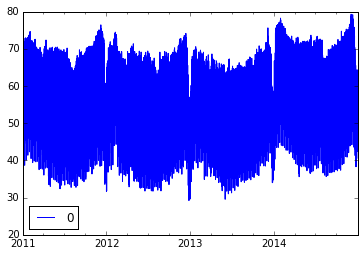

In [45]:
pd.DataFrame(load.sum(axis=1)).plot()

In [46]:
load_distribution = network.loads_t.p_set.loc[network.snapshots[0]].groupby(network.loads.bus).sum()

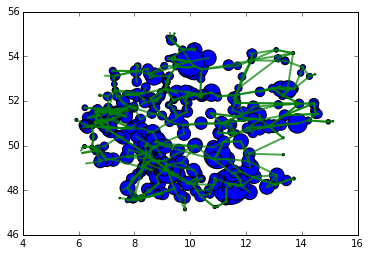

In [47]:
network.plot(bus_sizes=load_distribution)

In [48]:
total_load = load.sum(axis=1)

In [49]:
monthly_load = total_load.resample("M").sum()

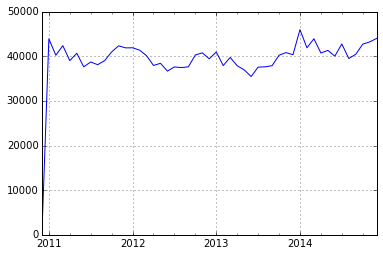

In [50]:
monthly_load.plot(grid=True)

# Attach conventional generators from BNetzA list

In [51]:
from vresutils import shapes as vshapes

def read_kraftwerksliste(with_latlon=True):                                                                              
                                                                                                              
    kraftwerke = pd.read_csv('../../lib/vresutils/data/Kraftwerksliste_CSV_deCP850ed.csv',                                         
                             delimiter=';', encoding='utf-8', thousands='.', decimal=',')                                
    def sanitize_names(x):                                                                                               
        try:                                                                                                             
            x = x[:x.index('(')]                                                                                         
        except ValueError:                                                                                               
            pass                                                                                                         
        return x.replace(u'\n', u' ').strip()
    kraftwerke.columns = kraftwerke.columns.map(sanitize_names)
    
    def sanitize_plz(x):
        try:
            x = x.strip()
            if len(x) > 5:
                x = x[:5]
            return float(x)
        except (ValueError, AttributeError):
            return np.NAN
    kraftwerke.PLZ = kraftwerke.PLZ.apply(sanitize_plz)
    if with_latlon:
        postcodes = {pc: sh.centroid
                     for pc, sh in iteritems(vshapes.postcodeareas())
                     if sh is not None}
        kraftwerke['lon'] = kraftwerke.PLZ.map({pc: c.x for pc, c in iteritems(postcodes)})
        kraftwerke['lat'] = kraftwerke.PLZ.map({pc: c.y for pc, c in iteritems(postcodes)})
        #kraftwerke.dropna(subset=('lon','lat'), inplace=True)                                                           

    kraftwerke[u'Type'] = kraftwerke[u"Auswertung Energieträger"].map({
        u'Erdgas': u'Gas',
        u'Grubengas': u'Gas',
        u'Laufwasser': u'Run of River',
        u'Pumpspeicher': u'Pumped Hydro',
        u'Speicherwasser (ohne Pumpspeicher)': u'Storage Hydro',
        u'Mineralölprodukte': u'Oil',
        u'Steinkohle': u'Hard Coal',
        u'Braunkohle': u'Brown Coal',
        u'Abfall': u'Waste',
        u'Kernenergie': u'Nuclear',
        u'Sonstige Energieträger\n(nicht erneuerbar) ': u'Other',
        u'Mehrere Energieträger\n(nicht erneuerbar)': u'Multiple',
        u'Biomasse' : u'Biomass',
        u'Deponiegas' : u'Gas',
        u'Klärgas' : u'Gas',
        u'Geothermie' : u'Geothermal',
        u'Windenergie (Onshore-Anlage)' : u'Wind Onshore',
        u'Windenergie (Offshore-Anlage)' : u'Wind Offshore',
        u'Solare Strahlungsenergie' : u'Solar',
        u'Unbekannter Energieträger\n(nicht erneuerbar)' : u'Other'
    })

    return kraftwerke

In [52]:
power_plants = read_kraftwerksliste()

Serving call to postcodeareas from file vresutils.shapes.postcodeareas_ver2__.pickle of cache: 85.7 msec


In [53]:
power_plants[power_plants[u"Unternehmen"] == "EEG-Anlagen < 10 MW"].groupby(u"Type").sum()

,PLZ,Netto-Nennleistung,lon,lat
Type,,,,
Biomass,NaN,5444.6,NaN,NaN
Gas,NaN,497.0,NaN,NaN
Geothermal,NaN,31.7,NaN,NaN
Run of River,NaN,1438.4,NaN,NaN
Solar,NaN,37008.7,NaN,NaN
Wind Onshore,NaN,24394.9,NaN,NaN


In [54]:
power_plants.groupby(u"Type").sum()

,PLZ,Netto-Nennleistung,lon,lat
Type,,,,
Biomass,3016585.0,6678.72,639.913564,3213.997738
Brown Coal,2485734.0,22969.50,655.576325,3787.688000
Gas,14304542.0,29356.03,2579.020814,13424.719920
Geothermal,NaN,31.70,NaN,NaN
Hard Coal,5979186.0,31474.60,868.212204,5166.446722
Multiple,45772.0,152.70,7.118728,51.686962
Nuclear,618554.0,12068.00,77.599904,400.252062
Oil,2616997.0,4165.20,563.075179,2803.594992
Other,1516594.0,3037.80,303.710411,1750.250968


In [55]:
import random

#NB: bnetza extracted from BNetzA using

#./Kraftwerksdaten.ipynb


def backup_capacity_german_grid(G):   

    from shapely.geometry import Point

    plants = power_plants
    plants = plants[plants["Kraftwerksstatus"] == u"in Betrieb"]
    
    #remove EEG-receiving power plants - except biomass, these will be added later
    
    #it's necessary to remove biomass because we don't have coordinates for it
    
    for tech in ["Solar","Wind Onshore","Wind Offshore","Biomass"]:
        plants = plants[plants['Type'] != tech]
    
    cells = {n: d["region"]
             for n, d in G.nodes_iter(data=True)}

    def nodeofaplant(x):
        if np.isnan(x["lon"]) or np.isnan(x["lat"]):
            return random.choice(list(cells.keys()))
        p = Point(x["lon"], x["lat"])
        for n, cell in iteritems(cells):
            if cell.contains(p):
                return n
        else:
            return min(cells, key=lambda n: cells[n].distance(p))
    nodes = plants.apply(nodeofaplant, axis=1)

    capacity = plants['Netto-Nennleistung'].groupby((nodes, plants[u'Type'])).sum() / 1e3
    capacity.name = 'Capacity'

    return capacity


In [56]:
cap = backup_capacity_german_grid(graph)

In [57]:
cap.describe(),cap.sum(),type(cap)

(count    477.000000
 mean       0.218376
 std        0.442888
 min        0.000100
 25%        0.023100
 50%        0.062700
 75%        0.193700
 max        4.730000
 Name: Capacity, dtype: float64, 104.16513, pandas.core.series.Series)

In [58]:
print(cap[pd.isnull(cap)])

     Type        
141  Pumped Hydro   NaN
275  Other          NaN
Name: Capacity, dtype: float64


In [59]:
cap.fillna(0.1,inplace=True)

In [60]:

cap.index.levels[1]

Index([u'Brown Coal', u'Gas', u'Geothermal', u'Hard Coal', u'Multiple',
       u'Nuclear', u'Oil', u'Other', u'Pumped Hydro', u'Run of River',
       u'Storage Hydro', u'Waste'],
      dtype='object', name=u'Type')

In [61]:
m_costs = {"Gas" : 50.,
           "Brown Coal" : 10.,
           "Hard Coal" : 25.,
           "Oil" : 100.,
           "Nuclear" : 8.,
           "Pumped Hydro" : 3.,
           "Storage Hydro" : 3.,
           "Run of River" : 3.,
           "Geothermal" : 26.,
           "Waste" : 6.,
           "Multiple" : 28.,
           "Other" : 32.}

default_cost = 10.

In [62]:
for (bus_name,tech_name) in cap.index:
    print(bus_name,tech_name,cap[(bus_name,tech_name)])
    if tech_name == "Pumped Hydro":
        network.add("StorageUnit",bus_name + " " + tech_name,
                bus=bus_name,p_nom=1000*cap[(bus_name,tech_name)],
                marginal_cost=m_costs.get(tech_name,default_cost),
                carrier=tech_name,
                max_hours = 6,
                efficiency_store=0.95,
                efficiency_dispatch=0.95)
    else:
        network.add("Generator",bus_name + " " + tech_name,
                bus=bus_name,p_nom=1000*cap[(bus_name,tech_name)],
                marginal_cost=m_costs.get(tech_name,default_cost),
                carrier=tech_name)   

1 Gas 0.121
1 Hard Coal 0.272
100_220kV Pumped Hydro 0.1445
102 Gas 0.0679
108 Run of River 0.0631
108 Waste 0.038
111 Gas 0.0135
112 Gas 0.0135
112 Run of River 0.0111
114 Hard Coal 0.019
114 Pumped Hydro 0.138
115 Brown Coal 4.73
116 Gas 0.5433
118 Gas 0.095
118 Waste 0.012
119 Brown Coal 0.0093
119 Gas 0.0169
119 Hard Coal 0.0615
121 Brown Coal 0.0246
121 Pumped Hydro 0.238
123_220kV Brown Coal 3.455
123_220kV Gas 0.0965
126 Gas 0.002
126 Oil 0.06
127 Brown Coal 1.8
127 Waste 0.024
128_220kV Run of River 0.0364
129_220kV Hard Coal 0.0615
12_220kV Gas 0.15
12_220kV Waste 0.03
130 Hard Coal 0.085
130 Waste 0.03
131 Gas 0.5863
132 Storage Hydro 0.029
133 Brown Coal 0.137
133 Waste 0.0334
134 Brown Coal 0.118
136 Gas 0.838
136 Hard Coal 0.765
137 Gas 0.0114
139 Hard Coal 0.76
14 Run of River 0.027
140 Gas 0.0111
140 Pumped Hydro 0.1
141 Gas 0.0647
141 Pumped Hydro 0.1
142 Gas 0.0098
142 Hard Coal 0.449
145 Brown Coal 0.0753
145 Gas 0.5365
145 Other 0.0798
145 Waste 0.0451
146 Gas 0.084


# Add renewables

In [63]:
import generation.germany as DEgen

reload(DEgen)

generation = DEgen.timeseries_eeg(graph)



Caching call to timeseries_eeg in generation.germany.timeseries_eeg_scigrid_v2_.pickle: 
.. Get eeg onshore wind timeseries from REatlas: 
.. .. Caching call to eeg_windonlayouts_per_class in generation.germany.eeg_windonlayouts_per_class_scigrid_v2_Cutout_beckerEurope_2011_2014_.pickle: 
.. .. .. Caching call to capacity_layouts_wind in generation.germany.capacity_layouts_wind__cutout.Cutout_beckerEurope_2011_2014_normed.False_turbines.e325f1f75c97f4e5a4146db18354d997c44e9185.pickle: 
.. .. .. .. Serving call to postcodes2gridcells from file generation.germany.postcodes2gridcells_Cutout_beckerEurope_2011_2014_.pickle of cache: 121.2 msec
.. .. .. .. 4.5 sec
.. .. .. 317.9 sec
.. .. 890.8 sec
.. Get eeg offshore wind timeseries from REatlas: 
.. .. Caching call to eeg_windofflayouts_per_class in generation.germany.eeg_windofflayouts_per_class_scigrid_v2_Cutout_beckerEurope_2011_2014_.pickle: 49.0 msec
.. .. 424.1 sec
.. Get eeg solar timeseries from REatlas: 
.. .. Caching call to eeg_

In [64]:
generation.items

Index([u'solar', u'wind', u'windoff', u'windon'], dtype='object')

In [65]:
#Kill the Timezone information to avoid pandas bugs
generation.major_axis = generation.major_axis.values

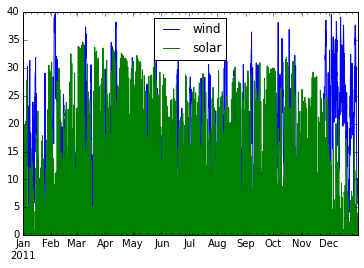

In [66]:
generation.loc[["wind","solar"],network.snapshots,:].sum(axis=2).plot()

In [67]:
solar = generation.loc["solar",network.snapshots,:].sum(axis=1)
solar.describe()

count    8760.000000
mean        5.978042
std         8.963907
min         0.000000
25%         0.000000
50%         0.000000
75%        11.014865
max        34.577076
dtype: float64

In [68]:
#make sure the ordering of the minor axis is correc
generation.minor_axis = graph.nodes()

# Get the capacities correct

In [69]:
cutout = vresutils.reatlas.Cutout(cutoutname="Europe_2011_2014", username="becker")

In [70]:
def panel_capacity(panel):
    """
    Returns the panel capacity in MW.
    
    Parameters
    ----------
    panel : string
        Panel name, e.g. "Sunpower"
    
    Returns
    -------
    capacity : float
        In MW
    """
    c = vresutils.reatlas.solarpanelconf_to_solar_panel_config_object(panel)
    return c['A'] + c['B'] * 1000 + c['C'] * np.log(1000)

In [71]:
solar_layouts = DEgen.eeg_solarlayouts(graph,cutout)

Serving call to eeg_solarlayouts from file generation.germany.eeg_solarlayouts_scigrid_v2_Cutout_beckerEurope_2011_2014_.pickle of cache: 137.9 msec


In [72]:
panel_cap = panel_capacity(solar_layouts[0]["panel"])
solar_caps = pd.Series(solar_layouts[1].sum(axis=(1,2))*panel_cap,
                       graph.nodes())

In [73]:
solar_caps.describe(),solar_caps.sum()

(count    489.000000
 mean       0.075750
 std        0.093728
 min        0.000028
 25%        0.012453
 50%        0.042313
 75%        0.100619
 max        0.849577
 dtype: float64, 37.041524779087617)

In [74]:
(generation.solar.max()/solar_caps).describe()

count    489.000000
mean       0.983755
std        0.018969
min        0.948734
25%        0.970006
50%        0.984081
75%        0.996938
max        1.043963
dtype: float64

In [75]:
windon_layouts = DEgen.eeg_windonlayouts_per_class(graph,cutout)

Serving call to eeg_windonlayouts_per_class from file generation.germany.eeg_windonlayouts_per_class_scigrid_v2_Cutout_beckerEurope_2011_2014_.pickle of cache: 842.1 msec


In [76]:
windon_capacities = pd.DataFrame(index=graph.nodes())
for turbine_items in windon_layouts:
    name = turbine_items[0]["onshore"]
    turbine_cap = np.array(vresutils.reatlas.turbineconf_to_powercurve_object(name)["POW"]).max()
    print(name,turbine_cap)
    windon_capacities[name] = turbine_items[1].sum(axis=(1,2))*turbine_cap/1000.

Vestas_V25_200kW 0.2001
Vestas_V47_660kW 0.66
Bonus_B1000_1000kW 1.0
Suzlon_S82_1.5_MW 1.5
Vestas_V66_1750kW 1.75
Vestas_V80_2MW_gridstreamer 2.0
Siemens_SWT_2300kW 2.3
Vestas_V90_3MW 3.0


In [77]:
windon_caps = windon_capacities.sum(axis=1)
windon_caps.describe(),windon_caps.sum()

(count    489.000000
 mean       0.076360
 std        0.146817
 min        0.000000
 25%        0.002402
 50%        0.020759
 75%        0.085740
 max        1.297764
 dtype: float64, 37.339895329191734)

In [78]:
(generation.windon.max()/windon_caps).describe()

count    488.000000
mean       0.999618
std        0.004390
min        0.909028
25%        0.999927
50%        0.999961
75%        0.999985
max        1.000000
dtype: float64

In [79]:
windoff_layouts = DEgen.eeg_windofflayouts_per_class(graph,cutout)

Serving call to eeg_windofflayouts_per_class from file generation.germany.eeg_windofflayouts_per_class_scigrid_v2_Cutout_beckerEurope_2011_2014_.pickle of cache: 585.6 msec


In [80]:
windoff_capacities = pd.DataFrame(index=graph.nodes())
for i,turbine_items in enumerate(windoff_layouts):
    name = turbine_items[0]["offshore"]
    turbine_cap = np.array(vresutils.reatlas.turbineconf_to_powercurve_object(name)["POW"]).max()
    print(name,turbine_cap)
    #add an index to name to avoid duplication of names
    windoff_capacities[name+"-" + str(i)] = turbine_items[1].sum(axis=(1,2))*turbine_cap/1000.

Siemens_SWT_2300kW_hornsrev2 2.3
NREL_ReferenceTurbine_5MW_offshore 5.0
NREL_ReferenceTurbine_5MW_offshore 5.0
Siemens_SWT_107_3600kW 3.6
Siemens_SWT_107_3600kW 3.6
NREL_ReferenceTurbine_5MW_offshore 5.0


In [81]:
windoff_capacities.sum()

Siemens_SWT_2300kW_hornsrev2-0          0.0483
NREL_ReferenceTurbine_5MW_offshore-1    0.0600
NREL_ReferenceTurbine_5MW_offshore-2    0.4000
Siemens_SWT_107_3600kW-3                1.4472
Siemens_SWT_107_3600kW-4                0.1080
NREL_ReferenceTurbine_5MW_offshore-5    0.9100
dtype: float64

In [82]:
windoff_caps = windoff_capacities.sum(axis=1)
windoff_caps.describe(),windoff_caps.sum()

(count    489.000000
 mean       0.006081
 std        0.081966
 min        0.000000
 25%        0.000000
 50%        0.000000
 75%        0.000000
 max        1.447200
 dtype: float64, 2.9735)

In [83]:
(generation.windoff.max()/windoff_caps).describe()

count    5.000000e+00
mean     1.000000e+00
std      1.263743e-08
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      1.000000e+00
dtype: float64

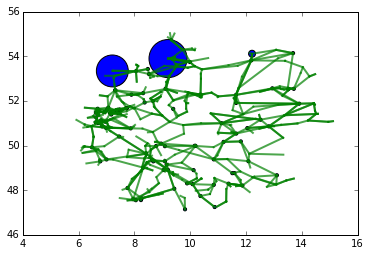

In [84]:
network.plot(bus_sizes=1000*windoff_caps)

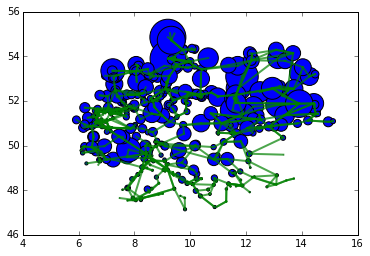

In [85]:
network.plot(bus_sizes=1000*windon_caps)

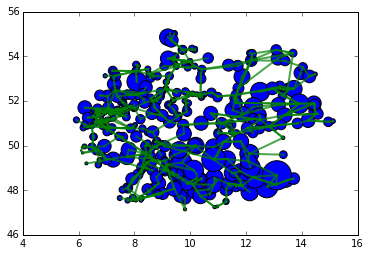

In [86]:
network.plot(bus_sizes=1000*solar_caps)

In [87]:

d = {"windoff" : {"full_name" : "Wind Offshore", "caps" : windoff_caps},
    "windon" : {"full_name" : "Wind Onshore", "caps" : windon_caps},
    "solar" : {"full_name" : "Solar", "caps" : solar_caps},
     }

for tech in ["windoff",'windon',"solar"]:
    caps = d[tech]["caps"]
    caps = caps[caps != 0]
    
    for i in caps.index:
        network.add("Generator","{} {}".format(i,d[tech]["full_name"]),
                    p_nom=caps[i]*1000.,dispatch="variable",
                    bus=i,carrier=d[tech]["full_name"],
                    p_max_pu=generation[tech].loc[network.snapshots,i]/caps[i])

In [88]:
csv_folder_name = "../../lib/data/de_model/scigrid-with-load-gen-trafos"

network.export_to_csv_folder(csv_folder_name)

In [89]:
network.set_snapshots(network.snapshots[:24])

csv_folder_name = "../../lib/pypsa/examples/scigrid-de/scigrid-with-load-gen-trafos"


network.export_to_csv_folder(csv_folder_name)